<a href="https://colab.research.google.com/github/zoegarm/Creando-Textos-con-DL/blob/main/Proyecto_LSTM_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM: 

1. Explicación del problema a resolver (cuáles son los inputs y porqué, cual es la salida y porqué, cómo se obtuvieron y de dónde)

    ``
    Aquí presento la importancia de predecir el siguiente caracter, así como por qué elijo analizar la entrada de cada caracter en lugar de palabras, de dónde agarré los datos y cómo le hice, jeje.
    ``

2. Análisis de los datos (histogramas, visualización de una muestra tanto la entrada como la salida, normalización en caso de ser necesaria)

    ``
    Aquí presento mi bónito set de 400 000 caácteres
    ``

3. Separación de los datos (seleccionar un porcentaje para cada conjunto: train, validation y test)

    ``
    Aquí explico por qué no tengo qué separar datos... 
    ``

4. Definición, Entrenamiento y Evaluación de la red neuronal

    ``
    Aquí presento mi red, la entreno y evalúo la red
    ``

5. Inferencia (usando los datos de prueba)

    ``
    Aquí hago la predicción
    ``

6. Comentario: explicar porqué se obtuvieron esos resultados

    ``
    Aquí explico mis resultados :) 
    ``


## importo dependencias

In [ ]:
import tensorflow as tf

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("physical_devices-------------", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Input, Flatten, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.utils import plot_model

import numpy as np
import os

import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns


# import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import io
path = '/content/drive/MyDrive/TSFCI/Amado Nervo.txt'
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()
print(len(text))

425207


In [ ]:
text

"\x0cdiario del doctor\n\n\nel doctor abrió su diario, recorrió las páginas escritas, con mirada negligente: llegó a la última,\nsobre la cual su atención se posó un poco más, como\nqueriendo coger el postrer eslabón a que debe soldarse uno nuevo, y en seguida tomó la pluma.\nen el gabinete “se oía el silencio”, un silencio dominical, un silencio de ciudad luterana en día de fiesta.\nméxico se desbandaba hacia la reforma, hacia los\nteatros, hacia los pueblecillos del valle, y en medinas\ntodo era paz: una paz de calle aristocrática, turbada con\nraros intervalos por el monofónico rodar de un coche\no por la bocanada de aire que arrojaba indistinto y melancólico a los hogares, un eco de banda lejana, un\nmotivo de carmen o de aída.\nel doctor —decíamos— tomó la pluma y escribió lo\nsiguiente, a continuación de la última nota de su diario:\ndomingo 14 de julio de 1886. estoy triste y un poco\nsoñador. tengo la melancolía del atardecer dominical. la misma total ausencia de afectos… ¡ni u

In [ ]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars)) #diccionario de caracter a indice
indices_char = dict((i, c) for i, c in enumerate(chars)) #de indice a caracter

total chars: 78


In [ ]:
sentences = []
next_chars = []
for i in range(0, len(text) - 40, 3):
    sentences.append(text[i: i + 40]) #listas de longitud 40
    next_chars.append(text[i + 40])   #lista del siguiente caracter en la lista

# otra version de one hot encoding con bool:
x = np.zeros((len(sentences), 40, len(chars)), dtype=np.int)
y = np.zeros((len(sentences), len(chars)), dtype=np.int)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1       #lista que tiene el índice de la sentencia, el índice de caracter en la sentencia y el índice del caracter en el diccionario
    y[i, char_indices[next_chars[i]]] = 1   #lista con índice de sentencia en el diccionario con respecto al siguiente caracter

In [ ]:
# Creates a model given an activation and learning rate

learning_rate = 0.01
opt = keras.optimizers.RMSprop(lr=learning_rate)

model_save = ModelCheckpoint('best_model.hdf5', save_best_only = True)
early_stopping = EarlyStopping(monitor = 'loss', patience= 5)

def create_model(learning_rate, opt = opt):
  
  model = Sequential()
  model.add(LSTM(128, input_shape=(40, len(chars))))
  model.add(BatchNormalization()) #extra
  model.add(Dropout(0.2)) #extra

  model.add(Dense(len(chars), activation='softmax'))

  #opt = keras.optimizers.RMSprop(lr=learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])


  return model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model = create_model(0.01, opt=opt)

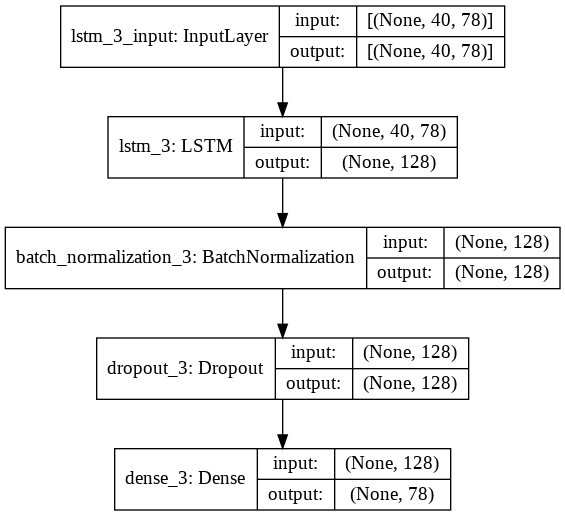

In [ ]:
plot_model(model, show_shapes=True, expand_nested=True, show_layer_names=True)

Refino mis hiperparámetros

In [ ]:
opt_list = [tf.keras.optimizers.Adam(lr = learning_rate), tf.keras.optimizers.Adamax(lr=learning_rate),
            tf.keras.optimizers.SGD(lr = learning_rate), keras.optimizers.RMSprop(lr=learning_rate)]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Entrenando y haciendo predicciones: 

In [ ]:
epochs = 5
batch_size = 128
maxlen = 40
step = 3
output_len = 400
temperatura = 0.1

#entrenamiento
h_call = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

#elijo un index al azar:
start_index = random.randint(0, len(text) - maxlen - 1)
print('start index: ', start_index)


generated = ""
sentence = text[start_index : start_index + maxlen]
print('...Generating with seed: "' + sentence + '"')

for i in range(output_len):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.0 #codifica el mensaje elegido 
    preds = model.predict(x_pred, verbose=0)[0] #lo pasa al predictor y lo predice esto nos regresa una matriz de 1x78
    # print('preds', preds, preds.shape)
    next_index = sample(preds, temperatura) #decodifica la predicción
    # print('next_index', next_index)
    next_char = indices_char[next_index] # obtenemos el caracter
    # print('next_char', next_char)
    sentence = sentence[1:] + next_char #damos el siguiente caracter a la sentencia para seguir en el for loop

    generated += next_char #se lo pegamos a la secuencia que predecimos

print("...Generated: ", generated)
print()

Epoch 1/5
997/997 [==============================] - 13s 11ms/step - loss: 2.2914 - accuracy: 0.3145 - val_loss: 2.0982 - val_accuracy: 0.3601
Epoch 2/5
997/997 [==============================] - 10s 10ms/step - loss: 2.0818 - accuracy: 0.3739 - val_loss: 1.9266 - val_accuracy: 0.4025
Epoch 3/5
997/997 [==============================] - 10s 10ms/step - loss: 1.9572 - accuracy: 0.4145 - val_loss: 1.8630 - val_accuracy: 0.4344
Epoch 4/5
997/997 [==============================] - 10s 10ms/step - loss: 1.8813 - accuracy: 0.4387 - val_loss: 1.7916 - val_accuracy: 0.4621
Epoch 5/5
997/997 [==============================] - 10s 10ms/step - loss: 1.8271 - accuracy: 0.4549 - val_loss: 1.7685 - val_accuracy: 0.4683
start index:  208816
...Generating with seed: "luz intermitente del faro del balneario."
...Generated:   la mantando de la concida de la vida de la mismo a su consinta la consinta de la vida de la consinta de la vida de la vida de la mano de la vida de la mantando de la mantar a la am

In [ ]:
def plot(h_call, save = True, name = None):  
  sns.set_style('darkgrid')
  plt.figure(figsize=(5,4))

  plt.title('Cost vs Epoch')
  plt.ylabel('Cost')
  plt.xlabel('Epoch')

  plt.plot(h_call.history['loss'], label = 'loss', color = 'redbrick')
  plt.plot(h_call.history['val_loss'], label = 'val_loss')

  plt.legend(loc = 'upper right')

  if save:
    plt.savefig(name + 'png')

  plt.show()

In [ ]:
plot(h_call, save=False)

ValueError: ignored

<Figure size 360x288 with 1 Axes>

In [ ]:
# # Create a dataframe from val_loss_per_function
# val_loss= pd.DataFrame(val_loss_per_function)

# # Call plot on the dataframe
# val_loss.plot()
# plt.show()

# # Create a dataframe from val_acc_per_function
# val_acc = pd.DataFrame(val_acc_per_function)

# # Call plot on the dataframe
# val_acc.plot()
# plt.show()

Hiper parámetros: